In [1]:
# encoding=utf8  
import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange
import tensorflow as tf

In [2]:
# Read the data into a list of strings.
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = np.compat.asstr(f.read(f.namelist()[0])).split()
    return data
# 单词表

file_zip_path = "./word2vec/text8.zip"
words = read_data(file_zip_path)
# Data size
print('Data size', len(words))
print(words[:5])

Data size 17005207
['anarchism', 'originated', 'as', 'a', 'term']


In [3]:
# Step 2: Build the dictionary and replace rare words with UNK token.
# 只留50000个单词，其他的词都归为UNK
vocabulary_size = 50000

def build_dataset(words, vocabulary_size):
    count = [['UNK', -1]]
    # extend追加一个列表
    # Counter用来统计每个词出现的次数
    # most_common返回一个TopN列表，只留50000-1个单词 然后加上UNK，一共50000个词
    # 前50000个出现次数最多的词
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    # 生成 dictionary，词对应编号, word:id(0-49999)
    # 词频越高编号越小
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    # data把数据集的词都编号
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    # 记录UNK词的数量
    count[0][1] = unk_count
    # 编号对应词的字典
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

# data 数据集，编号形式
# count 前50000个出现次数最多的词
# dictionary 词对应编号
# reverse_dictionary 编号对应词
data, count, dictionary, reverse_dictionary = build_dataset(words, vocabulary_size)
del words  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [4]:
def get_words_index(words_map:dict,word:str):
    if word in words_map:
        return words_map[word]
    else:
        return words_map["UNK"]

def get_words_by_index(words_map:dict,index:str):
    if index in words_map:
        return words_map[index]
    else:
        return "UNK"

def hanleData(word_ids,selhalfwidth=1):
    words_list = []
    labels_list=[]
    words_size = len(word_ids) - selhalfwidth
    index = selhalfwidth
    label_indexList = []
    i = -selhalfwidth
    while(i<=selhalfwidth):
        if i !=0:
            label_indexList.append(i)
        i += 1
    while(index<words_size):
        word_id = word_ids[index]
        random.shuffle(label_indexList)
        for labelIndex in label_indexList:
            words_list.append(word_id)
            label_id = word_ids[index + labelIndex]
            labels_list.append(label_id)
        index += 1
    return words_list,labels_list

In [5]:
#处理数据 生成input和labels
train_words, train_labels = hanleData(data,1)

In [18]:
# 打印sample data
print("dataset_size = ",len(train_words))
for i in range(8):
    print(train_words[i], reverse_dictionary[train_words[i]],
        '->', train_labels[i], reverse_dictionary[train_labels[i]])

dataset_size =  34010410
3081 originated -> 12 as
3081 originated -> 5234 anarchism
12 as -> 6 a
12 as -> 3081 originated
6 a -> 12 as
6 a -> 195 term
195 term -> 6 a
195 term -> 2 of


In [19]:
def batch_data_iterator(targets,labels,batch_size):
    total_size = min(len(targets),len(labels))
    epoch =  math.ceil(total_size / batch_size)
    current_batch_index = 0
    while(True):
        start_index = current_batch_index * batch_size
        end_index = min((current_batch_index + 1) * batch_size,total_size)
        yield targets[start_index:end_index] ,labels[start_index:end_index]
        current_batch_index = (current_batch_index + 1) % epoch

In [20]:
####model
EMBEDDING_SIZE = 128
tf.reset_default_graph()
target_placeholder = tf.placeholder(tf.int32,[None],name="target_inputs")
label_placeholder = tf.placeholder(tf.int32,[None],name="label_inputs")
label_reshape = tf.reshape(label_placeholder,[-1,1],name="label_reshape")
valid_list_v = tf.Variable(np.random.choice(100, size=16, replace=False),name='valid_list',trainable=False)
global_step = tf.Variable(0,trainable=False)

embedding_map = tf.Variable(tf.random_normal([vocabulary_size,EMBEDDING_SIZE]))
embedding = tf.nn.embedding_lookup(embedding_map,target_placeholder)

weights=tf.Variable(tf.truncated_normal([vocabulary_size,EMBEDDING_SIZE],stddev=1.0/math.sqrt(EMBEDDING_SIZE)))
biases = tf.Variable(tf.zeros([vocabulary_size])+0.01)

loss_t = tf.reduce_mean(tf.nn.nce_loss(weights,biases,label_reshape,embedding,64,EMBEDDING_SIZE),name="loss")

learning_rate_t = tf.train.exponential_decay(0.001,global_step,1000,0.95,staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate_t).minimize(loss_t,global_step=global_step)

normal_embedding_map = embedding_map/tf.sqrt(tf.reduce_sum(tf.square(embedding_map),axis=1,keep_dims=True)) #50000,128

valid_embedding_p = tf.nn.embedding_lookup(normal_embedding_map,valid_list_v)   #16,128

similarity_t = tf.matmul(valid_embedding_p,normal_embedding_map,transpose_b=True,name="similarity")  #16*50000

In [25]:
EPOCH = 50000
BATCH_SIZE = 102400
SAVE_CKPT_DIR="./ckpt/"

batch_data_iter = batch_data_iterator(train_words,train_labels,BATCH_SIZE)

saver = tf.train.Saver(max_to_keep=2)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    latest_ck = tf.train.latest_checkpoint(SAVE_CKPT_DIR)
    if latest_ck :
        print("Load ckpt", latest_ck)
        saver.restore(sess,latest_ck)
    for epoch in range(EPOCH):
        batch_target,batch_label = batch_data_iter.__next__()
        loss,lr,_ = sess.run([loss_t,learning_rate_t,optimizer],feed_dict={target_placeholder:batch_target,label_placeholder:batch_label})
        if epoch %500 == 0:
            print("[{}/{}]  loss = {}   learningRate = {}".format(epoch,EPOCH,loss,lr))
        if epoch %2500 == 0:
            valid_list,similarityMap = sess.run([valid_list_v,similarity_t],feed_dict={target_placeholder:batch_target,label_placeholder:batch_label})
            for index,valid in enumerate(valid_list):
                output_line = "[Similar]  %s : "%(reverse_dictionary[valid])
                similarity = similarityMap[index]
                sim_words_indexes = (-similarity).argsort()[1:5]
                for word_index in sim_words_indexes:
                    output_line = "%s   %s[%.2f%%] "%(output_line,reverse_dictionary[word_index],similarity[word_index]*100)
                print(output_line)
        if epoch != 0 and epoch % 5000 == 0:
            saver.save(sess,SAVE_CKPT_DIR+'/ckpt.cpkt',epoch)
    final_embedding = embedding_map.eval()

[0/50000]  loss = 71.48719787597656   learningRate = 0.0010000000474974513
[Similar]  many :    mingus[40.13%]    dismisses[34.00%]    adventurers[33.63%]    safer[33.29%] 
[Similar]  some :    abnormally[35.86%]    pierluigi[34.82%]    aroma[34.80%]    larch[34.58%] 
[Similar]  up :    pluriform[32.64%]    novel[31.92%]    forgetting[31.80%]    greenhouse[31.62%] 
[Similar]  six :    assur[35.82%]    mane[33.53%]    athos[32.63%]    cunning[32.18%] 
[Similar]  in :    symbolizes[32.57%]    hoppers[32.25%]    mazzola[32.04%]    shao[32.01%] 
[Similar]  a :    hiawatha[35.01%]    criminalization[33.56%]    lemass[33.24%]    dancer[31.92%] 
[Similar]  history :    schleicher[35.81%]    reisman[35.33%]    commissioner[33.49%]    proudhon[33.31%] 
[Similar]  as :    fashioning[34.20%]    unmistakable[33.81%]    lugo[32.79%]    libyan[31.96%] 
[Similar]  only :    keywork[38.50%]    safeguard[37.56%]    duane[36.20%]    india[36.11%] 
[Similar]  during :    duplications[35.39%]    oppressed

[10500/50000]  loss = 2.3842198848724365   learningRate = 0.0005987368640489876
[11000/50000]  loss = 2.3391530513763428   learningRate = 0.0005688000237569213
[11500/50000]  loss = 2.3188514709472656   learningRate = 0.0005688000237569213
[12000/50000]  loss = 2.4069840908050537   learningRate = 0.0005403600516729057
[12500/50000]  loss = 2.322031259536743   learningRate = 0.0005403600516729057
[Similar]  many :    mingus[42.81%]    electrically[38.25%]    adventurers[36.52%]    summarized[35.30%] 
[Similar]  some :    gods[35.87%]    pierluigi[35.70%]    ecclesiasticus[35.33%]    larch[35.22%] 
[Similar]  up :    scrooge[37.89%]    moby[37.10%]    backside[36.52%]    yogurt[35.80%] 
[Similar]  six :    nine[37.75%]    diaz[37.38%]    assur[36.00%]    dist[34.98%] 
[Similar]  in :    symbolizes[38.32%]    magnetometer[36.05%]    ivanhoe[35.48%]    hyperplasia[34.50%] 
[Similar]  a :    lemass[37.70%]    behaved[36.45%]    hiawatha[35.98%]    decadence[34.51%] 
[Similar]  history :    

[22000/50000]  loss = 2.4100229740142822   learningRate = 0.00032353345886804163
[22500/50000]  loss = 2.3586838245391846   learningRate = 0.00032353345886804163
[Similar]  many :    mingus[42.27%]    adventurers[38.33%]    electrically[36.25%]    summarized[35.09%] 
[Similar]  some :    gods[37.09%]    pierluigi[35.72%]    ecclesiasticus[34.85%]    several[34.29%] 
[Similar]  up :    scrooge[37.25%]    greenhouse[36.46%]    backside[35.44%]    moby[35.26%] 
[Similar]  six :    nine[38.30%]    kilojoules[36.72%]    dist[35.96%]    pilgrimage[35.53%] 
[Similar]  in :    symbolizes[40.48%]    magnetometer[36.78%]    frontman[34.14%]    hyperplasia[34.06%] 
[Similar]  a :    behaved[38.14%]    lemass[37.00%]    an[35.19%]    waals[34.28%] 
[Similar]  history :    foreseeable[37.84%]    modules[35.87%]    zamora[35.61%]    sickness[35.48%] 
[Similar]  as :    ventilated[36.71%]    lugo[36.45%]    fashioning[36.41%]    transpersonal[36.29%] 
[Similar]  only :    keywork[42.19%]    safeguard

[33000/50000]  loss = 2.322706460952759   learningRate = 0.00018402583373244852
[33500/50000]  loss = 2.3489325046539307   learningRate = 0.00018402583373244852
[34000/50000]  loss = 2.3499929904937744   learningRate = 0.00017482454131823033
[34500/50000]  loss = 2.3288097381591797   learningRate = 0.00017482454131823033
[35000/50000]  loss = 2.4759485721588135   learningRate = 0.00016608330770395696
[Similar]  many :    mingus[41.56%]    adventurers[38.88%]    summarized[35.13%]    several[35.04%] 
[Similar]  some :    gods[37.64%]    pierluigi[35.66%]    several[35.53%]    ecclesiasticus[34.26%] 
[Similar]  up :    repeating[36.41%]    scrooge[36.13%]    muscovite[36.05%]    greenhouse[35.71%] 
[Similar]  six :    nine[38.29%]    kilojoules[37.66%]    pilgrimage[36.34%]    dist[35.53%] 
[Similar]  in :    symbolizes[41.23%]    magnetometer[37.21%]    proverbial[34.77%]    std[34.37%] 
[Similar]  a :    behaved[38.35%]    lemass[36.62%]    an[35.20%]    medically[35.07%] 
[Similar]  h

[45000/50000]  loss = 2.297333002090454   learningRate = 9.944020712282509e-05
[Similar]  many :    mingus[41.20%]    adventurers[39.01%]    several[36.24%]    summarized[35.12%] 
[Similar]  some :    gods[37.81%]    several[35.92%]    pierluigi[35.62%]    ecclesiasticus[34.00%] 
[Similar]  up :    repeating[37.38%]    muscovite[36.33%]    scrooge[35.66%]    greenhouse[35.13%] 
[Similar]  six :    nine[38.16%]    kilojoules[37.88%]    pilgrimage[36.59%]    quickdraw[35.78%] 
[Similar]  in :    symbolizes[41.47%]    magnetometer[37.34%]    proverbial[35.02%]    std[34.72%] 
[Similar]  a :    behaved[38.32%]    lemass[36.51%]    medically[35.45%]    an[35.17%] 
[Similar]  history :    foreseeable[38.02%]    modules[36.22%]    levels[36.21%]    zamora[36.00%] 
[Similar]  as :    ventilated[41.13%]    fashioning[35.68%]    unmistakable[35.31%]    suited[35.29%] 
[Similar]  only :    keywork[39.89%]    safeguard[37.33%]    duane[35.50%]    cryptids[35.44%] 
[Similar]  during :    criollo[39

In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30,n_components=2,init='pca',n_iter=5000,method='exact')

plot_only = 500
low_dim_embs = tsne.fit_transform(final_embedding[:plot_only,:])
labels = [reverse_dictionary[i] for i in range(plot_only)]

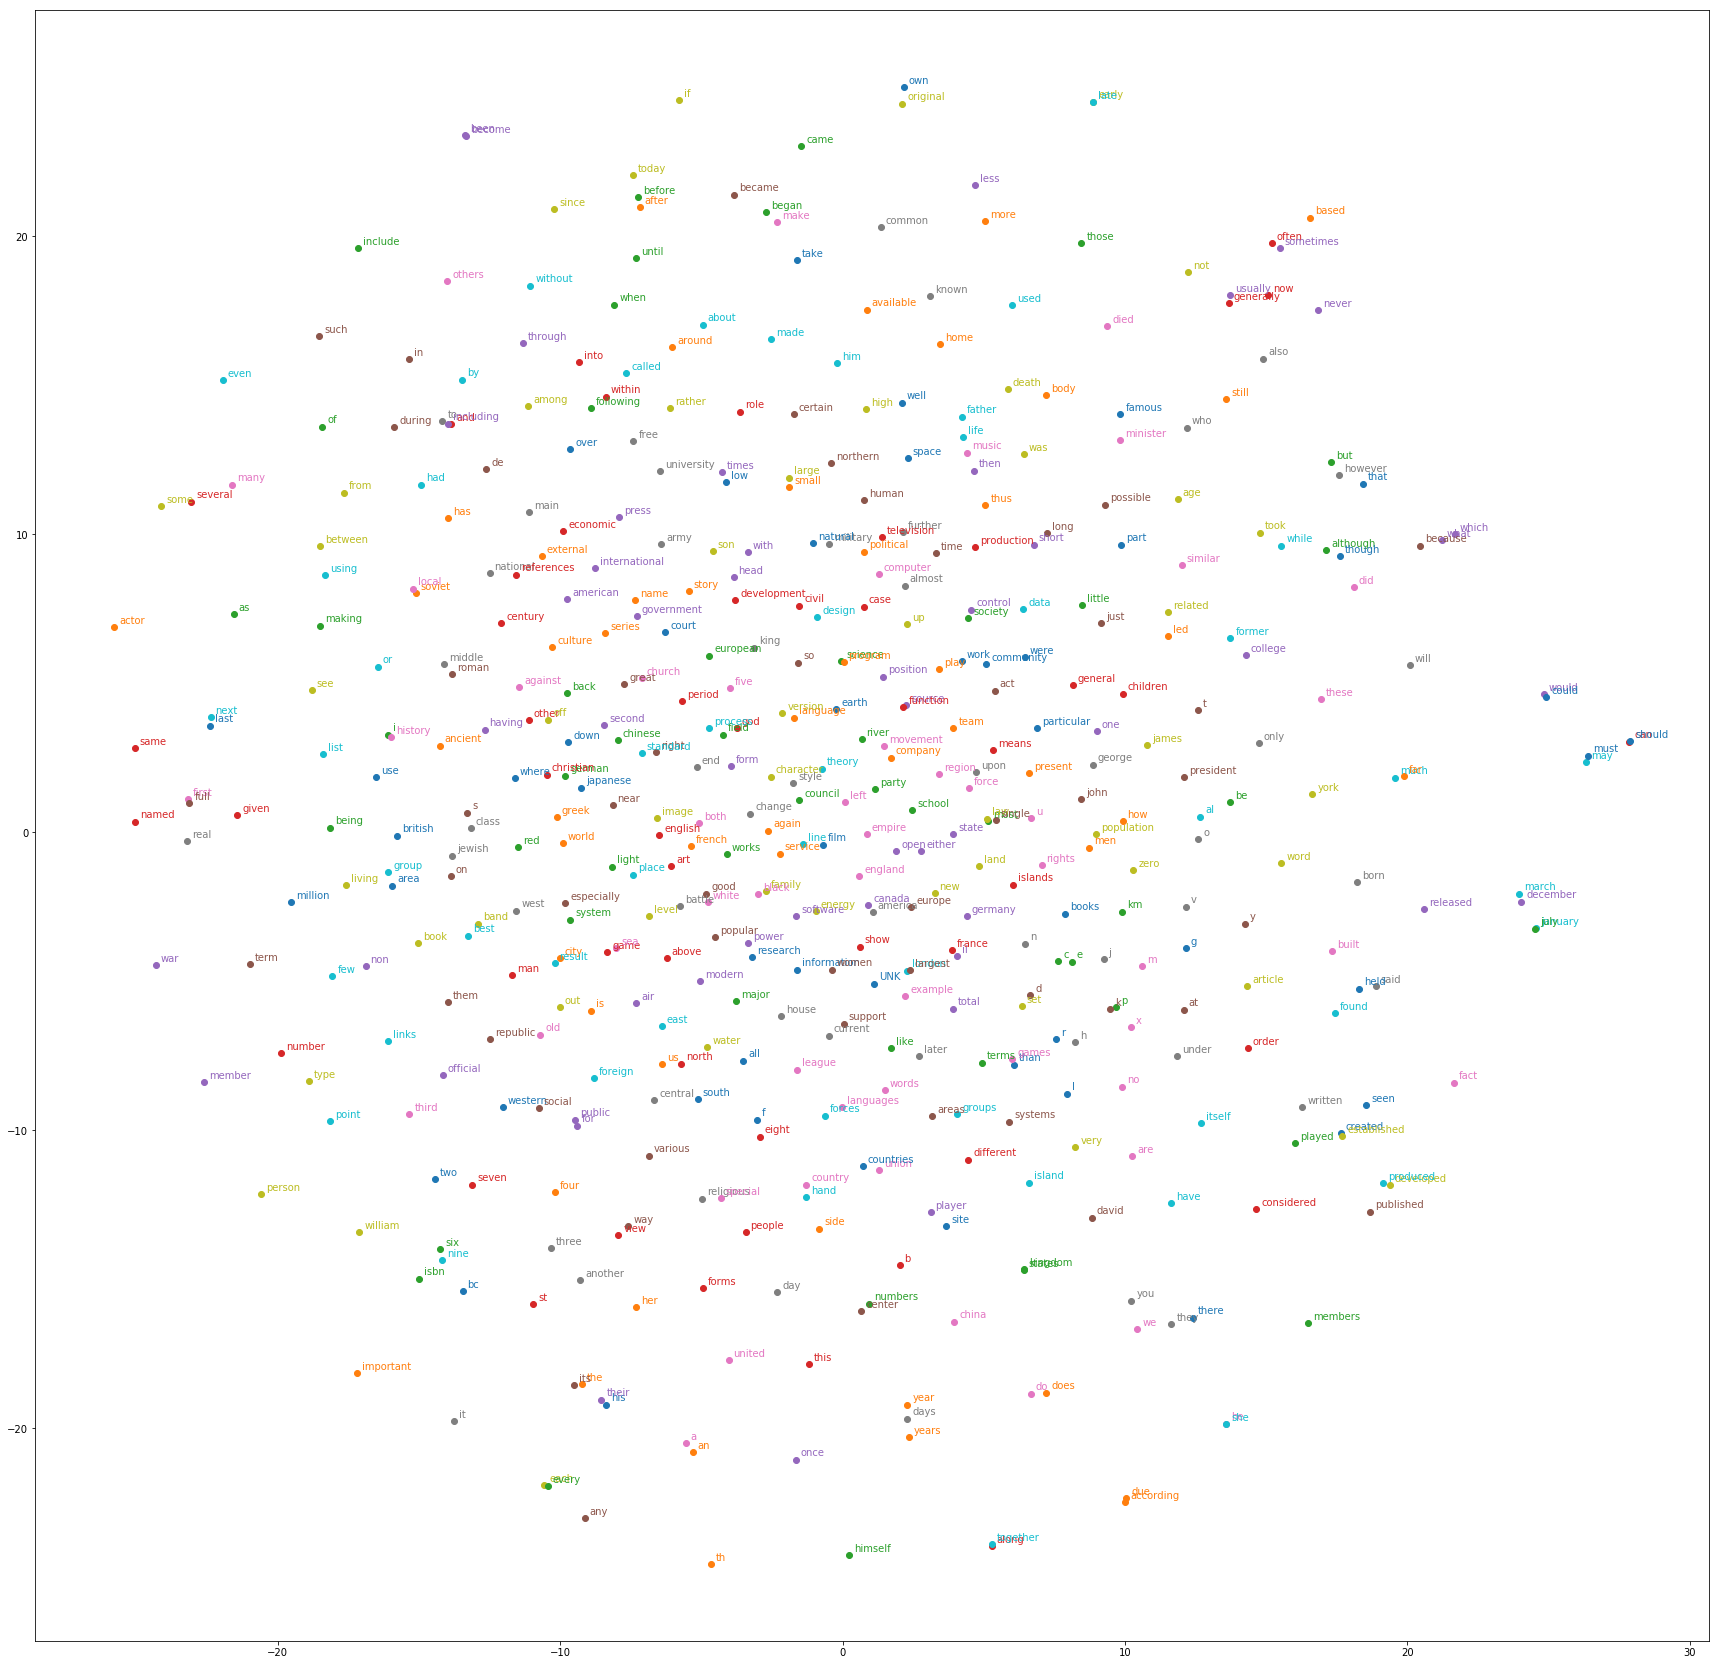

In [27]:
plt.figure(figsize=(30,30))
for i,label in enumerate(labels):
    x,y = low_dim_embs[i,:]
    args = plt.scatter(x,y)
    color = args.get_edgecolor()[0]
    plt.annotate(label,xy=(x,y),xytext=(5,2),textcoords='offset points',color=color,ha='left',va='bottom')
plt.show()